# SRRF ODMR Anlaysis adapted for more than 1 ND

The aim of this script is to take a 2D scan of a nanodiamond (or cluster in the future) and to find the fluorescence intensity for the ND by fitting a gaussian curve to the data and recording the max amplitude of the curve. From this Gaussian curve, it is possible to also extract the x and y resolution limits by looking at the FWHM of the curve. 

From here, I will also import the SRRF data for the ND in question (I have previously generated the drift table and the SRRF dataset for the image). I will then run the same program and compare the two datasets. 

The data will be saved into a text file and a secondary script will be used to analyse this data... Or I'll tag it on to the bottom of this script, I haven't decided yet. 

In [1]:
import numpy as np 
import scipy.optimize as opt 
import matplotlib.pyplot as plot 
import pandas as pd 
import skimage.feature as si
from mpl_toolkits import mplot3d

In [2]:
def get_data(file_location):
    '''Here we take the file location for the 2D dataset and 
    load it into a numpy array. '''
    
    # Open the file and read in the dataset.
    with open(file_location, 'r') as stack_2D:
        # data saved into content.
        content = stack_2D.read()
    
    # Sort data into two variables , one with the image data (scan_array)
    # and another with the meta data for the image. 
        # intialise variables. 
    image_data = []
    scan_metadata = []
    store_scan_metadata = []
    
    # ignore the first 6 lines of the array (plain text)
    lines = content.splitlines()[6:]
    for line in lines:
        # remove the "new line" text from the row. 
        row = line.split('\t')
        # Save metadata and PSF scan data in separate variables (done by length due to ease)
        # as strings
        if len(row) < 20:
            store_scan_metadata.append(row)
            continue 
        image_data.append(row[0:len(row)-1])
    
    # Extract the metadata for the scan used to create the data_set. 
    scan_metadata = np.array(store_scan_metadata[4]
                             [0:len(store_scan_metadata[4])-1]).astype(float)

    # convert the scan_array list into a float array. 
    image_array = np.array(image_data, dtype = np.float)
    
    return(image_array, scan_metadata)    

In [3]:
def generate_3D_scan_range(scan_data):
    
    x_scan = np.linspace(0, scan_data[2]-scan_data[1], int(scan_data[3]))
    y_scan = np.linspace(0, scan_data[5]-scan_data[4], int(scan_data[6]))
    z_scan = np.linspace(0, scan_data[8]-scan_data[7], int(scan_data[9]))
    
    # In python, the 3D stack shape is (z, x, y)
    psf_array_shape = [int(scan_data[9]),  int(scan_data[3]),  int(scan_data[6])]
    
    return([x_scan, y_scan, z_scan], psf_array_shape)

In [4]:
def get_total_fluorescence(scan_data):
    '''This is a mother designed to calculate the total fluorescence per z line within 
    the variable "scan_data". This can be either the full stack dataset, a subset of 
    the data or a single frame.'''
    
    total_fluorescence = []
    
    # If the data is a 3D dataset then find the total fluorescence for each 
    # image in stack.
    if len(scan_data.shape) == 3:
        loops = scan_data.shape[0]
        for i in range(loops):
            total_fluorescence.append( np.sum(scan_data[i, :,:]) )
    
    # If scan_data is a single frame (2D dataset), total_fluorescence is the sum of all 
    # pixels in the scan. 
    else: 
        loops = 1
        total_fluorescence.append( np.sum(scan_data) )            
    
    return(total_fluorescence)
    

In [39]:
def find_nd_substacks(single_frame, nd_locs, res_in_pixels):
    '''This method is designed to generate substacks from the first image that surround
    or capture the individual NDs within an image.'''
    
    sub_scans = [] # np.empty([len(nd_locs), 4*res_in_pixels, 4*res_in_pixels])
    
    for i in range (len(nd_locs)):
        # Set the boundries for the sub-scans around an 
        # ND for each ND in nd_locs. If the ND lies near the 
        # boarder, then the upper/lower limit for the scan is 
        # the end of the array.
        low_y = nd_locs[i][0]-2*res_in_pixels
        if low_y < 0:
            low_y = 0
            
        high_y = nd_locs[i][0]+2*res_in_pixels
        if high_y > len(single_frame[:,0]):
            high_y = len(single_frame[:,0])-1
          
        low_x = nd_locs[i][1]-2*res_in_pixels
        if low_x < 0:
            low_x = 0
            
        high_x = nd_locs[i][1]+2*res_in_pixels
        if high_x > len(single_frame[0,:]):
            high_x = len(single_frame[:,0])-1
        
        sub_scans.append(single_frame[low_y:high_y, low_x:high_x])
        
    return(sub_scans)

In [37]:
def fit_gaussians(sub_stack, pixel_size):
    '''This function takes the sub-stacks from an image that surround an ND
    and fits a gaussian to the dataset. This dataset is used to determine the 
    maximum fluorescence and the FWHM for the NDs in the dataset.'''
    
    # Initial values for the fitting params
    amp = np.max(sub_stack[0])
    FWHM = 10
    mean_pos_x = 10
    
    fwhm_x = []
    fwhm_y = []
    max_fluorescence = []
    
    p0 = [amp, mean_pos_x, FWHM]
    
    for i in range(len(sub_stack)):
        image = np.array(sub_stack[i])
        
        nd_pos = si.peak_local_max(image, min_distance = 5, 
                           exclude_border = True, num_peaks = 1)
        
        x = np.linspace(0, image.shape[1]-1, len(image[0, :]))
        y = np.linspace(0, image.shape[0]-1, len(image[:, 0]))
        
        # fit a gaussian to each 2D image for x and y data. 
        opt_x_fit, x_conf = opt.curve_fit(gaussian, x, image[nd_pos[0][0],:], p0)
        opt_y_fit, y_conf = opt.curve_fit(gaussian, y, image[:, nd_pos[0][1]], p0)
        
        # Create a high resolution y fit for the gaussian curves for analysis
        high_res_x = np.linspace(0, image.shape[1]-1, 10*len(image[0, :]))
        high_res_y = np.linspace(0, image.shape[0]-1, 10*len(image[:,0]))
    
        high_res_x_fit = gaussian(high_res_x, opt_x_fit[0], opt_x_fit[1], opt_x_fit[2])
        high_res_y_fit = gaussian(high_res_y, opt_y_fit[0], opt_y_fit[1], opt_y_fit[2])

        # Extract the FWHM from the gaussian curves. 
        fwhm_x.append(find_fwhm(high_res_x_fit, high_res_x, opt_x_fit)*pixel_size)
        fwhm_y.append(find_fwhm(high_res_y_fit, high_res_y, opt_y_fit)*pixel_size)
        
        # Exctract maximum brightness
        max_fluorescence.append(np.max(high_res_y_fit))
    
    return(fwhm_x, fwhm_y, max_fluorescence)
    

In [7]:
def gaussian(x, amp, mean_position, FWHM):
    '''A single dimensional gaussian fitting.'''
    
    y = amp*np.exp(-(x-mean_position)**2/(2*np.power(FWHM,2)))  
    return(y)

In [8]:
def find_fwhm(y_fit, fine_x, opt_fit_y):
    '''Find the FWHM for a gaussian fit'''

    index = []
    # find the indicies for which the gaussian curve has a 
    # value greater than 1/2 the max value. 
    for i in range(len(y_fit)):
        if y_fit[i] >= opt_fit_y[0]/2:
            index.append(i)
    
    index = np.array(index)
    
    # Calculate the FWHM.
    fwhm_in_pixles = fine_x[np.max(index)] - fine_x[np.min(index)]   
    
    return(fwhm_in_pixles)

In [9]:
def get_srrf_image(srrf_image_loc):
    '''load the SRRF data into a numpy array'''
    
    srrf_image_data = np.loadtxt(srrf_image_loc)
    return(srrf_image_data)

[[21 14]
 [26 44]]
mean total image fluorescence = 70587.94
x resolution = [0.32238493723849376, 0.32290502793296094]
y resolution = [0.34163179916317993, 0.3368200836820084]
Mean fluorescence from ND 1 = [21541.0]
Mean fluorescence from ND 2 = [19560.0]


Text(0.5, 1.0, '2D scan of the ND under study')

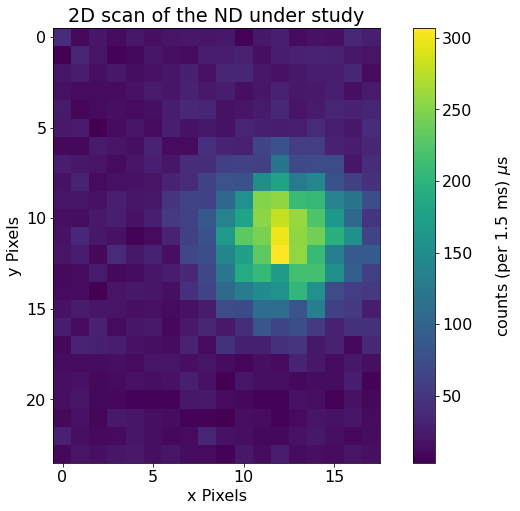

In [65]:
'''Here we start the actual running of the code for the 2D analysis.'''

folder_path = 'I:\\Science\\Physics-Nanobiophotonics\\Group\\User Data\\ODMR\\Imaging\\'
date = '20210423'
file_name = date + '_SRRF_Scan_07'

nds_present = 2 # Input the numebr of NDs in an image. 

plot.rcParams.update({'font.size' : 16})
plot.rcParams.update({'figure.figsize' :[12, 8]})

# Get the scan data from the file location.
scan_data, meta_data = get_data(folder_path + date+ '\\' + file_name + '.dat')

pixel_size = (meta_data[2]-meta_data[1])/(meta_data[3]-1) # in  microns

scan_range, data_array_shape = generate_3D_scan_range(meta_data)

# reshape PSF array to 3D object. z, y, x 
scan_data = scan_data.reshape(data_array_shape[0], data_array_shape[1],
                 data_array_shape[2])

# find the total fluorescence for each frame in the image stack. 
total_fluorescence = get_total_fluorescence(scan_data) 

# Find the resolution limit of the microscope in pixels. 
res_limit = 0.26 # Confocal resolution limit in microns.

res_limit_in_pixels = int(np.ceil(res_limit/pixel_size)) # confocal resolution in pixels. 

# Find the NDs in the sample
nd_loc = si.peak_local_max(scan_data[0,:,:], min_distance = 1*res_limit_in_pixels, 
                           exclude_border = True, num_peaks = nds_present)
print(nd_loc)
nd_sub_stacks = find_nd_substacks(scan_data[0,:,:], nd_loc, res_limit_in_pixels)

fwhm_x, fwhm_y, max_ND_signals = fit_gaussians(nd_sub_stacks, pixel_size)

mean_ND1_fluorescence = get_total_fluorescence(nd_sub_stacks[0])
mean_ND2_fluorescence = get_total_fluorescence(nd_sub_stacks[1])

print('mean total image fluorescence = ' + str(np.mean(total_fluorescence)))
print('x resolution = ' + str(fwhm_x))
print('y resolution = ' + str(fwhm_y))
print('Mean fluorescence from ND 1 = ' + str(mean_ND1_fluorescence))
print('Mean fluorescence from ND 2 = ' + str(mean_ND2_fluorescence))

plot.imshow(nd_sub_stacks[1])
plot.colorbar( label = '\ncounts (per 1.5 ms)' + r' $\mu$s')
plot.xlabel('x Pixels')
plot.ylabel('y Pixels')
plot.title('2D scan of the ND under study')

In [63]:
'''Here we start the analysis of the SRRF image. '''

# Set the name of the SRRF image 
srrf_file = file_name + ' - SRRF_image'

# Get the SRRF image data (This has its own function as it is a text file filled with numbers. )
srrf_image = get_srrf_image(folder_path + date + '\\' + srrf_file +'.txt')

# Find the scale of the SRRF image compared to the confocal image. 
srrf_pixel_res_scale = [srrf_image.shape[0]/scan_data.shape[1], srrf_image.shape[1]/scan_data.shape[2]]
srrf_pixel_res = pixel_size/srrf_pixel_res_scale # in microns. 

# Find the ND in the sample
srrf_nd_loc = si.peak_local_max(srrf_image, min_distance = 10, 
                                exclude_border = True, num_peaks = nds_present)
print(srrf_nd_loc)
# Generate a sub-stack for analysis 
sub_nd_srrf_stacks = find_nd_substacks(srrf_image, srrf_nd_loc, 10)

# Get the total fluorescence from the SRRF image and the FWHM for the ND in question. 
srrf_total_fluorescence = get_total_fluorescence(srrf_image) 

srrf_fwhm_x, srrf_fwhm_y, max_signal = fit_gaussians(sub_nd_srrf_stacks, srrf_pixel_res)

mean_SRRF_ND1 = get_total_fluorescence(sub_nd_srrf_stacks[0])
mean_SRRF_ND2 = get_total_fluorescence(sub_nd_srrf_stacks[1])

print('mean total image fluorescence = ' + str(np.mean(srrf_total_fluorescence)))
print('x resolution = ' + str(srrf_fwhm_x))
print('y resolution = ' + str(srrf_fwhm_y))
print('Mean fluorescence from ND 1 = ' + str(mean_SRRF_ND1))
print('Mean fluorescence from ND 2 = ' + str(mean_SRRF_ND2))

[[153 269]
 [134  85]]
mean total image fluorescence = 284.75500000000005
x resolution = [array([0.05946115, 0.05946115]), array([0.0806391, 0.0806391])]
y resolution = [array([0.06434837, 0.06434837]), array([0.07738095, 0.07738095])]
Mean fluorescence from ND 1 = [36.80800000000001]
Mean fluorescence from ND 2 = [39.629000000000005]


Text(0.5, 1.0, 'SRRF Scan of the ND under study')

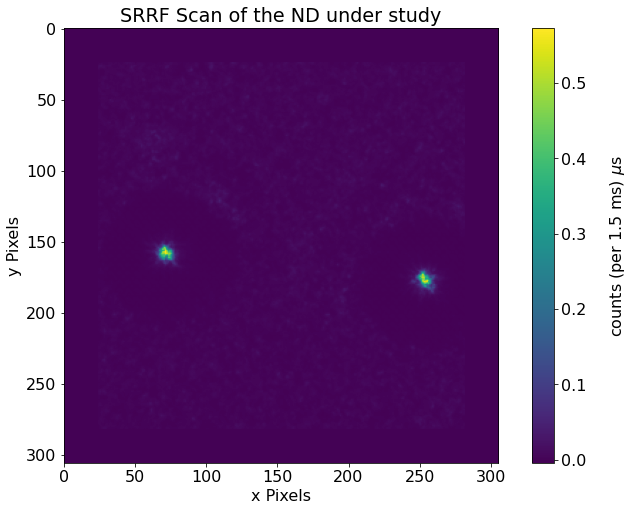

In [28]:
plot.imshow(srrf_image)
plot.colorbar( label = '\ncounts (per 1.5 ms)' + r' $\mu$s')
plot.xlabel('x Pixels')
plot.ylabel('y Pixels')
plot.title('SRRF Scan of the ND under study')

### Code note

The next part of the code is designed to look at the drop in the total fluorescence recorded during a SRRF image stack with time. I will also extend this analysis to all of the sub-stacks for the NDs that are in an image to see what the drift is like in terms of the 

This loss in counts is being put down to drift in the sample. 

[81239.0, 81888.0, 80481.0, 80402.0, 79684.0, 80224.0, 77947.0, 78698.0, 76963.0, 77828.0, 77060.0, 78614.0, 78160.0, 77803.0, 77537.0, 78138.0, 78185.0, 78334.0, 77723.0, 77148.0, 76946.0, 76471.0, 76397.0, 75071.0, 75959.0, 77677.0, 76275.0, 77007.0, 74629.0, 75481.0, 74573.0, 75137.0, 75272.0, 74352.0, 74006.0, 74295.0, 74518.0, 73665.0, 73742.0, 73990.0, 73013.0, 72949.0, 73322.0, 74310.0, 74278.0, 74350.0, 74539.0, 74436.0, 74483.0, 74478.0, 73892.0, 74471.0, 72662.0, 73547.0, 73563.0, 72900.0, 73239.0, 73330.0, 73595.0, 73078.0, 71754.0, 73462.0, 73440.0, 73223.0, 73340.0, 73100.0, 74153.0, 74252.0, 73209.0, 73796.0, 74419.0, 73854.0, 73694.0, 73247.0, 73399.0, 73294.0, 74343.0, 72228.0, 74216.0, 74066.0, 72751.0, 72205.0, 72755.0, 72248.0, 73057.0, 72593.0, 71889.0, 71273.0, 73019.0, 71080.0, 71815.0, 72250.0, 71791.0, 72262.0, 72467.0, 73329.0, 72162.0, 73499.0, 72868.0, 72068.0]


Text(0, 0.5, 'Total fluorescence in image')

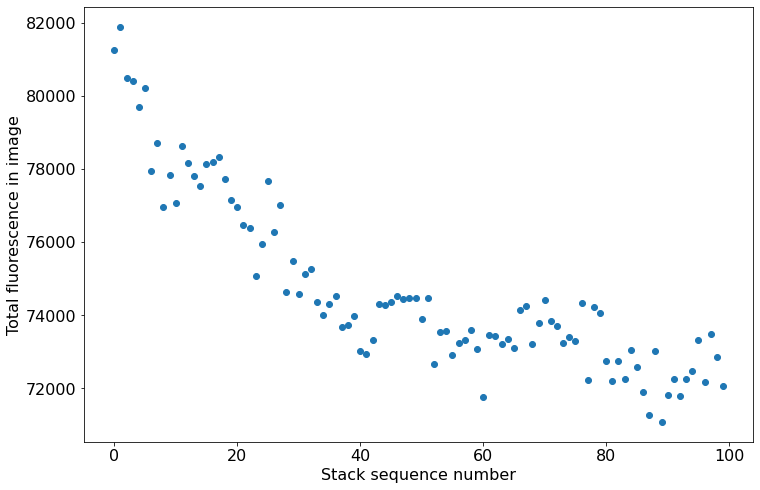

In [29]:
x = np.linspace(0, 99 , 100)
total_counts = []

for i in range (100):
    total_counts.append((np.sum(scan_data[i, :,:])))

print(total_counts)

plot.scatter(x, total_counts)
plot.xlabel('Stack sequence number')
plot.ylabel('Total fluorescence in image')
